In [ ]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
data = pd.read_csv('/content/reviews.csv',
header=None, names = ('review','sentiment'), sep='\t')
# информация о наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31552 entries, 0 to 31551
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     31552 non-null  object
 1   sentiment  31551 non-null  object
dtypes: object(2)
memory usage: 493.1+ KB


In [ ]:
print(data.head())
print(data.tail())

                                              review  sentiment
0                                             review  sentiment
1  качество плохое пошив ужасный (горловина напер...   negative
2  Товар отдали другому человеку, я не получила п...   negative
3  Ужасная синтетика! Тонкая, ничего общего с пре...   negative
4  товар не пришел, продавец продлил защиту без м...   negative
                                                  review sentiment
31547  Материал говно, доставка быстрая! Картинка не ...  neautral
31548  Доставка месяц. Естественно синтетика. Размер ...  neautral
31549  качество не очень и маленькая, боковые карманы...  neautral
31550  Ожидала, что все резиночки будут разные - приш...  neautral
31551                           оказалась разная длина р       NaN


#Предобработка

In [ ]:
import re
import nltk
!pip install pymorphy3
from pymorphy3 import MorphAnalyzer
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 48.1 MB/s eta 0:00:00


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
morph = MorphAnalyzer()

texts = data['review'].astype(str)

def clean_text(text):

    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text

stop_words = set(stopwords.words('russian'))

def preprocess_text(text):

    text = clean_text(text)

    tokens = word_tokenize(text, language='russian')

    tokens = [word for word in tokens if word not in stop_words]
parse_cache = {}

def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text, language='russian')
    tokens = [word for word in tokens if word not in stop_words]
    # Лемматизация с кэшированием
    lemmatized_tokens = []
    for word in tokens:
        if word in parse_cache:
            lemma = parse_cache[word]
        else:
            lemma = morph.parse(word)[0].normal_form
            parse_cache[word] = lemma
        lemmatized_tokens.append(lemma)
    return ' '.join(lemmatized_tokens)

data['review'] = texts.apply(preprocess_text)

data.to_csv('clean.csv', index=False)

#Обучение модели

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [ ]:
data = pd.read_csv('/content/clean.csv', header=None, names=('review', 'sentiment'))

data = data.dropna(subset=['review'])

text_reviews = data['review'].values

y = data['sentiment'].values

text_reviews = [str(review) for review in text_reviews]

In [ ]:
print("Проверка NaN в text_reviews:", any(pd.isnull(review) for review in text_reviews))

Проверка NaN в text_reviews: False


In [ ]:
print("Проверка NaN в y:", pd.isnull(y).any())

Проверка NaN в y: True


In [ ]:
filtered_reviews = []
filtered_y = []

for review, label in zip(text_reviews, y):
    if review.strip() != '':
        filtered_reviews.append(review)
        filtered_y.append(label)

text_reviews = filtered_reviews
y = np.array(filtered_y)

In [ ]:
pipeline = make_pipeline(
    CountVectorizer(),
    LogisticRegression(n_jobs=-1, random_state=17)
)

pipeline.fit(text_reviews, y)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=17))])

In [ ]:
print("Точность на обучающей выборке:", round(pipeline.score(text_reviews, y), 3))

Точность на обучающей выборке: 0.966


In [ ]:
param_grid = {'logisticregression__C': np.logspace(-2, 3, 15)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
grid = GridSearchCV(pipeline, param_grid, cv=skf, n_jobs=-1)
grid.fit(text_reviews, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=17))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.00000000e-02, 2.27584593e-02, 5.17947468e-02, 1.17876863e-01,
       2.68269580e-01, 6.10540230e-01, 1.38949549e+00, 3.16227766e+00,
       7.19685673e+00, 1.63789371e+01, 3.72759372e+01, 8.48342898e+01,
       1.93069773e+02, 4.39397056e+02, 1.00000000e+03])})

In [ ]:
print("Лучшие параметры:", grid.best_params_)
print("Лучшее качество по кросс-валидации:", grid.best_score_)

Лучшие параметры: {'logisticregression__C': np.float64(0.022758459260747887)}
Лучшее качество по кросс-валидации: 0.951002794304929


In [ ]:
print("Длина coef:", len(coef))
print("Длина feature_names:", len(feature_names))

Длина coef: 126852
Длина feature_names: 31713


In [ ]:
np.argsort(coef)

array([60944, 94079, 57695, ..., 89408, 62366, 92657])

In [ ]:
print("Длина coef:", len(coef))
print("Длина feature_names:", len(feature_names))
print("coef:", coef)
print("feature_names:", feature_names)

Длина coef: 126852
Длина feature_names: 31713
coef: [-1.93836125e-06 -8.18570280e-07 -1.81977756e-06 ... -3.35236942e-06
  6.38188940e-07  1.09067853e-07]
feature_names: ['___' '______________________________________' '_other_reason_' ...
 'ёлочный' 'ёё' 'ヽдﾉ']


In [ ]:
print("Минимальный coef:", np.min(coef))
print("Максимальный coef:", np.max(coef))

Минимальный coef: -0.3916866238131024
Максимальный coef: 0.38918153226264723


In [ ]:
n_top_features = min(25, len(coef)//2)
print(n_top_features)

25


In [ ]:
coef = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()
feature_names = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names_out()

print("Длина coef:", len(coef))
print("Длина feature_names:", len(feature_names))
print("coef:", coef)
print("feature_names:", feature_names)

n_top_features = min(25, len(coef)//2)

positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

print("interesting_coefficients перед фильтрацией:", interesting_coefficients)

interesting_coefficients = interesting_coefficients[interesting_coefficients < len(feature_names)]

print("interesting_coefficients после фильтрации:", interesting_coefficients)

if len(interesting_coefficients) == 0:
    print("Нет достаточно интересных признаков для отображения.")
else:

    top_n = min(len(interesting_coefficients), 2 * n_top_features)

    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients][:top_n]]
    plt.bar(np.arange(top_n), coef[interesting_coefficients][:top_n], color=colors)
    plt.xticks(np.arange(top_n), feature_names[interesting_coefficients][:top_n], rotation=60, ha="right")
    plt.title("Топ слов по коэффициентам модели")
    plt.show()

Длина coef: 126852
Длина feature_names: 31713
coef: [-1.44345787e-06 -1.04000664e-06 -1.71166926e-06 ... -2.20113105e-06
  2.19461087e-07 -3.97310569e-07]
feature_names: ['___' '______________________________________' '_other_reason_' ...
 'ёлочный' 'ёё' 'ヽдﾉ']
interesting_coefficients перед фильтрацией: [60944 94079 57695 48978 55851 83269 93781 75102 78284 38434 60761 55304
 40009 58244 40620 67289 52001 59600 60324 89096 85395 79134 53264 36678
 60834 92547 68391 84977 47421 53682 57383 92037 35576 83714 72333 91313
 89957 87017 92474 71722 46571 70147 43389 62068 51556 87564 80691 89408
 62366 92657]
interesting_coefficients после фильтрации: []
Нет достаточно интересных признаков для отображения.


IndexError: index 60944 is out of bounds for axis 0 with size 31713

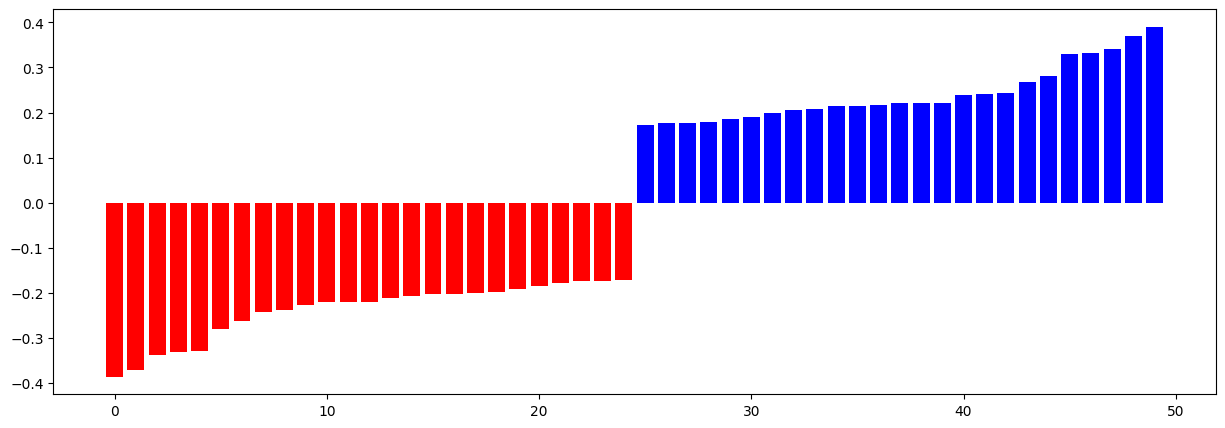

In [ ]:
coef = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()
feature_names = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names_out()

n_top_features = 25
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

plt.figure(figsize=(15, 5))
colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
plt.xticks(np.arange(2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right")
plt.title("Топ слов по коэффициентам модели")
plt.show()